# Imported Libraries <a class="anchor" id="libraries"></a>

In [2]:
#Importing Libraries
import time
import ray
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

2023-05-27 01:34:03.298911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Function Definations 

In [3]:
def split_dataset(data, tst_size):
    """
    Split the dataset into training and testing sets using speciifed test size and return X_train, X_test, y_train, y_test.

    Args:
        data (pandas.DataFrame): The loaded dataset.
        tst_size: The test size
    Returns:
        tuple: A tuple containing X_train, X_test, y_train, and y_test.
    """

    # Split the data into features (X) and target variable (y)
    X = data.iloc[:, :40]  
    y = data.iloc[:, 40:41]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tst_size, random_state=42)

    return X_train, X_test, y_train, y_test

In [4]:
# Define a function to create Shallow Learning Model (KNN)
def create_shallow_model():
    model = KNeighborsClassifier(n_neighbors=5)
    return model

In [5]:
#Define a function to call the create_Shallow_model() and train, returning the time and accuracy 
def create_and_train_shallow_model(X_train, y_train, X_test, y_test):
    #List to hold accuracy from KNN model
    knn_acc = []
    tpr_list = []
    fpr_list = []
    tnr_list = []
    fnr_list = []
    error_rate_list = []
    time_at_epoch = []
    # create object of model
    model = create_shallow_model()
    
    #define number of epochs
    num_epochs = 20
    
    #Variable to hold start time for seq SL 
    SL_seq_start_time = time.time()
    
    #compile knn model for a number of iterations and hold value to a list
    for _ in range(num_epochs):
        
        #time at the beginning of training per epoch
        start = time.time()
        
        #train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5).astype(int)
        
        #time at end of training per epoch
        stop = time.time()
        final = stop - start
        
        #append time per epoch to list
        time_at_epoch.append(final)
        
        #calculate confusion metrics
        cm = confusion_matrix(y_test, y_pred)
        
        accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
        knn_acc.append(accuracy)
        
        tpr = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) != 0 else 0.0
        tpr_list.append(tpr)
        
        fpr = cm[0, 1] / (cm[0, 1] + cm[1, 1]) if (cm[0, 1] + cm[1, 1]) != 0 else 0.0
        fpr_list.append(fpr)
        
        tnr = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) != 0 else 0.0
        tnr_list.append(tnr)
        
        fnr = 1 - tpr
        fnr_list.append(fnr)
        
        error_rate = (cm[0, 1] + cm[1, 0]) / np.sum(cm)
        error_rate_list.append(error_rate)
        
        print(f'Epoch {_ + 1} : Accuracy {accuracy}')
        
    #Variable to hold stop time for seq SL 
    SL_seq_stop_time = time.time()
    
    final_test_accuracy = knn_acc[-1]
    print("Shallow Learning Model Accuracy (KNN):", final_test_accuracy)


    #get final run time for SL sequential
    SL_seq_final_time = SL_seq_stop_time - SL_seq_start_time

    #Print runtime for SL sequential 
    print("Shallow Learning Model Sequential Training Total time (KNN):", SL_seq_final_time, "seconds")
    
    return knn_acc, SL_seq_final_time, model, tpr_list, fpr_list, tnr_list, fnr_list, error_rate_list, time_at_epoch

In [6]:
# Define a function to create Deep Learning Model (DNN)
# Define the Shallow Learning Model (DNN)
def create_deep_model(num_input, num_output):
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# Define a function to call the create_deep_model() and train, returning the time and accuracy
def train_deep_model(X_train, y_train, X_test, y_test):
    # create object of model
    model = create_deep_model(X_train.shape[1], len(np.unique(y_train)))
    DL_acc_list = []
    tpr_list = []
    fpr_list = []
    tnr_list = []
    fnr_list = []
    error_rate_list = []
    time_at_epoch = []
    num_epochs = 20
    
    # Variable to hold start time for seq DL
    DL_seq_start_time = time.time()
    
    for _ in range(num_epochs):
        #record training time at beginning of epoch
        start = time.time()
        
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=10, verbose=0)
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5).astype(int)
        
        #record time at end of training 
        stop = time.time()
        final =stop-start
        
        #append time to list
        time_at_epoch.append(final)
        
        #calculate confusion metrics 
        cm = confusion_matrix(y_test, (y_pred.argmax(axis=1)))

        # confusion matrix 'cm'

        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]

        # Calculate accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        DL_acc_list.append(accuracy)

        # Calculate error rate
        error_rate = (fp + fn) / (tp + tn + fp + fn)
        error_rate_list.append(error_rate)

        # Calculate true positive rate (TPR) or sensitivity or recall
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0.0
        tpr_list.append(tpr)

        # Calculate true negative rate (TNR) or specificity
        tnr = tn / (tn + fp) if (tn + fp) != 0 else 0.0
        tnr_list.append(tnr)

        # Calculate false positive rate (FPR)
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0.0
        fpr_list.append(fpr)

        # Calculate false negative rate (FNR)
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0.0
        fnr_list.append(fnr)
    # Variable to hold stop time for seq DL
    DL_seq_stop_time = time.time()
    
    final_test_accuracy = DL_acc_list[-1]
    print("Deep Learning Model Accuracy (DNN):", final_test_accuracy)

    # get final run time for DL sequential
    DL_seq_final_time = DL_seq_stop_time - DL_seq_start_time

    # Print runtime for SL sequential
    print("Deep Learning Model Sequential Training time (DNN):", DL_seq_final_time, "seconds")
    return DL_acc_list, DL_seq_final_time, model, tpr_list, fpr_list, tnr_list, fnr_list, error_rate_list, time_at_epoch


# 2.3 Machine learning model evaluation

## Extending the Code used in 2.2 to calculate the metrics

## Loading the data in the combined NSL_DL vector<a class="anchor" id="load_data">

In [8]:
# Load the combined preprocessed DS_NSL_Final dataset generated and exported to an excel sheet  from task 2.1
dataset = pd.read_excel("DS_NSL_Final.xlsx")

### Segmenting Combined NSL-KDD into 30% testing and 70% training, then display the numbers of columns and rows

In [9]:
X_train, X_test, y_train, y_test = split_dataset(dataset, 0.3)

In [10]:
# #reshape y_train and y_test
# y_train = y_train.ravel()
# y_test = y_test.ravel()

# Convert y_train DataFrame to numpy array and flatten it
y_train = y_train.values.ravel()

# Convert y_test DataFrame to numpy array and flatten it
y_test = y_test.values.ravel()

## Sequential Execution of KNN and DNN

### Shallow Learning Model KNN

In [11]:
knn_acc, SL_seq_final_time, KNN, tpr_knn, fpr_knn, tnr_knn, fnr_knn, error_rate_knn, time_at_epoch_knn =  create_and_train_shallow_model(X_train, y_train, X_test, y_test)

Epoch 1 : Accuracy 0.9830650922385175
Epoch 2 : Accuracy 0.9830650922385175
Epoch 3 : Accuracy 0.9830650922385175
Epoch 4 : Accuracy 0.9830650922385175
Epoch 5 : Accuracy 0.9830650922385175
Epoch 6 : Accuracy 0.9830650922385175
Epoch 7 : Accuracy 0.9830650922385175
Epoch 8 : Accuracy 0.9830650922385175
Epoch 9 : Accuracy 0.9830650922385175
Epoch 10 : Accuracy 0.9830650922385175
Epoch 11 : Accuracy 0.9830650922385175
Epoch 12 : Accuracy 0.9830650922385175
Epoch 13 : Accuracy 0.9830650922385175
Epoch 14 : Accuracy 0.9830650922385175
Epoch 15 : Accuracy 0.9830650922385175
Epoch 16 : Accuracy 0.9830650922385175
Epoch 17 : Accuracy 0.9830650922385175
Epoch 18 : Accuracy 0.9830650922385175
Epoch 19 : Accuracy 0.9830650922385175
Epoch 20 : Accuracy 0.9830650922385175
Shallow Learning Model Accuracy (KNN): 0.9830650922385175
Shallow Learning Model Sequential Training Total time (KNN): 52.37191104888916 seconds


In [12]:
# display metrics from knn in sequential
# Create a DataFrame
df_knn_seq = pd.DataFrame({
    'Time': time_at_epoch_knn,
    'Accuracy ': knn_acc,
    'TPR': tpr_knn,
    'FPR': fpr_knn,
    'TNR': tnr_knn,
    'FNR': fnr_knn,
    'Error Rate': error_rate_knn
})

# Add epoch column
df_knn_seq['Epoch'] = range(1, len(knn_acc) + 1)

# Set epoch as index
df_knn_seq.set_index('Epoch', inplace=True)

# Apply styling to the DataFrame
styled_df_knn_seq = df_knn_seq.style \
    .format('{:.4f}') \
    .background_gradient(cmap='Blues')
print('KNN Metrics from Sequential Execution')
# Display the styled DataFrame
styled_df_knn_seq

KNN Metrics from Sequential Execution


,Time,Accuracy,TPR,FPR,TNR,FNR,Error Rate
Epoch,,,,,,,
1,2.7855,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169
2,2.3510,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169
3,2.3818,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169
4,2.5525,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169
5,2.6942,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169
6,2.4795,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169
7,2.5075,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169
8,2.5121,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169
9,3.0236,0.9831,0.9833,0.0176,0.9824,0.0167,0.0169


### Deep Learning Model

In [13]:
#Train dnn
# Train the Deep Learning Model (DNN)
DL_acc_list, DL_seq_final_time, DNN, tpr_dnn, fpr_dnn, tnr_dnn, fnr_dnn, error_rate_dnn, time_at_epoch_dnn =  train_deep_model(X_train, y_train, X_test, y_test)

2023-05-27 01:35:34.793407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


744/744 [==============================] - 1s 650us/step
Deep Learning Model Accuracy (DNN): 0.7459343614741354
Deep Learning Model Sequential Training time (DNN): 1948.2285318374634 seconds


In [14]:
# display metrics from dnn in sequential
# Create a DataFrame
df_dnn_seq = pd.DataFrame({
    'Time': time_at_epoch_dnn,
    'Accuracy ': DL_acc_list,
    'TPR': tpr_dnn,
    'FPR': fpr_dnn,
    'TNR': tnr_dnn,
    'FNR': fnr_dnn,
    'Error Rate': error_rate_dnn
})

# Add epoch column
df_dnn_seq['Epoch'] = range(1, len(DL_acc_list) + 1)

# Set epoch as index
df_dnn_seq.set_index('Epoch', inplace=True)

# Apply styling to the DataFrame
styled_df_dnn_seq = df_dnn_seq.style \
    .format('{:.4f}') \
    .background_gradient(cmap='Blues')
print('DNN Metrics from Sequential Execution')
# Display the styled DataFrame
styled_df_dnn_seq

DNN Metrics from Sequential Execution


,Time,Accuracy,TPR,FPR,TNR,FNR,Error Rate
Epoch,,,,,,,
1,105.0426,0.7604,0.0574,0.0001,0.9999,0.9426,0.2396
2,117.6745,0.7527,0.0309,0.0013,0.9987,0.9691,0.2473
3,123.6362,0.7661,0.0799,0.0000,1.0000,0.9201,0.2339
4,113.1412,0.7494,0.0139,0.0000,1.0000,0.9861,0.2506
5,103.4466,0.7477,0.0071,0.0000,1.0000,0.9929,0.2523
6,93.8094,0.7461,0.0008,0.0000,1.0000,0.9992,0.2539
7,87.3770,0.7461,0.0008,0.0000,1.0000,0.9992,0.2539
8,86.5365,0.7468,0.0036,0.0000,1.0000,0.9964,0.2532
9,96.3523,0.7461,0.0008,0.0000,1.0000,0.9992,0.2539


## Parallel Execution of DNN and KNN

#### Split Data into batches

In [15]:
# # Split data into batches with fixed batch size
# batch_size = len(X_train) // 5  # Adjust the batch size as needed
# x_batches = np.array_split(X_train, batch_size)
# y_batches = np.array_split(y_train, batch_size)

X_train_batches = np.array_split(X_train, 20)
y_train_batches = np.array_split(y_train, 20)

In [16]:
'''
    when measuring the effect of parallelism using Ray, it is more meaningful to focus on the training time. 
    This allows you to compare the performance of parallel execution against sequential execution, 
    assess the speedup achieved, and understand the impact of parallelism on the training efficiency.
'''

'\n    when measuring the effect of parallelism using Ray, it is more meaningful to focus on the training time. \n    This allows you to compare the performance of parallel execution against sequential execution, \n    assess the speedup achieved, and understand the impact of parallelism on the training efficiency.\n'

### Function to train models in parallel

In [17]:
@ray.remote
def train_shallow_model(X_train, y_train, X_test, y_test):
    # Create and train the Shallow Learning Model (KNN)
    model = KNeighborsClassifier(n_neighbors=5)
    accuracies = []
    cm_list = []

    for _ in range(20):
        model.fit(X_train, y_train)
        accuracy = accuracy_score(y_test, model.predict(X_test))
        predictions = model.predict(X_test)
        cm = confusion_matrix(y_test, predictions)
        accuracies.append(accuracy)
        cm_list.append(cm)

    return accuracies[-1], model, cm_list[-1]

@ray.remote
def train_deep_model(X_train, y_train, X_test, y_test):
    # Create and train the Deep Learning Model (DNN)
    model = create_deep_model(X_train.shape[1], len(np.unique(y_train)))
    accuracies = []
    cm_list = []

    for _ in range(20):
        history = model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0)
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
        predictions = model.predict(X_test)
        y_pred = np.argmax(predictions, axis=1)
        cm = confusion_matrix(y_test, y_pred)
        accuracies.append(accuracy)
        cm_list.append(cm)

    return accuracies[-1], model, cm_list[-1]


#### KNN in Parallel

In [18]:
# Train the Shallow Learning Model (KNN) in parallel
knn_tasks = []
knn_results = []
knn_error_rate = []
knn_tpr = []
knn_tnr = []
knn_fpr = []
knn_fnr = []
time_at_epoch_knn_par = []
knn_accuracy = []

#start recording total training time in parallel
knn_start_time = time.time()

#initialize ray
ray.shutdown()
ray.init()

for i in range(20):
    #record training time per epoch 
    start = time.time()
    
    knn_tasks.append(train_shallow_model.remote(X_train_batches[i], y_train_batches[i], X_test, y_test))
    
    #record end time per epoch
    stop = time.time()
    final = stop - start
    
    #append time at the end of each epoch to list
    time_at_epoch_knn_par.append(final)
    
#stop recording total training time in parallel (knn)
knn_total_time = time.time() - knn_start_time
for task in knn_tasks:
    accuracy, model, cm = ray.get(task)
    knn_results.append(accuracy)

    # Calculate metrics
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]

    # Calculate error rate
    denominator = tp + tn + fp + fn
    if denominator != 0:
        error_rate = (fp + fn) / denominator
    else:
        error_rate = 0.0
    knn_error_rate.append(error_rate)

    # Calculate true positive rate (TPR) or sensitivity or recall
    tpr_denominator = tp + fn
    if tpr_denominator != 0:
        tpr = tp / tpr_denominator
    else:
        tpr = 0.0
    knn_tpr.append(tpr)

    # Calculate true negative rate (TNR) or specificity
    tnr_denominator = tn + fp
    if tnr_denominator != 0:
        tnr = tn / tnr_denominator
    else:
        tnr = 0.0
    knn_tnr.append(tnr)

    # Calculate false positive rate (FPR)
    fpr_denominator = fp + tn
    if fpr_denominator != 0:
        fpr = fp / fpr_denominator
    else:
        fpr = 0.0
    knn_fpr.append(fpr)

    # Calculate false negative rate (FNR)
    fnr_denominator = fn + tp
    if fnr_denominator != 0:
        fnr = fn / fnr_denominator
    else:
        fnr = 0.0
    knn_fnr.append(fnr)

    # Calculate accuracy
    accuracy_denominator = tp + tn + fp + fn
    if accuracy_denominator != 0:
        accuracy = (tp + tn) / accuracy_denominator
    else:
        accuracy = 0.0
    knn_accuracy.append(accuracy)




2023-05-27 02:08:07,884	INFO worker.py:1625 -- Started a local Ray instance.


In [19]:
# display time taken for both model in sequential and parallel 

# Print the sequential and parallel training times for KNN 
print("Sequential Training Total Time Time for KNN:", SL_seq_final_time, "seconds")
print("Parallel Training Total Time for KNN:", knn_total_time, "seconds")

Sequential Training Total Time Time for KNN: 52.37191104888916 seconds
Parallel Training Total Time for KNN: 5.974184989929199 seconds


In [20]:
# display metrics from knn in parallel
# Create a DataFrame
df_knn_par = pd.DataFrame({
    'Time': time_at_epoch_knn_par,
    'Accuracy ': knn_accuracy,
    'TPR': knn_tpr,
    'FPR': knn_fpr,
    'TNR': knn_tnr,
    'FNR': knn_fnr,
    'Error Rate': knn_error_rate
})

# Add epoch column
df_knn_par['Epoch'] = range(1, len(knn_results) + 1)

# Set epoch as index
df_knn_par.set_index('Epoch', inplace=True)

# Apply styling to the DataFrame
styled_df_knn_par = df_knn_par.style \
    .format('{:.4f}') \
    .background_gradient(cmap='Blues')
print('KNN Metrics from Parallel Execution')
# Display the styled DataFrame
styled_df_knn_par

KNN Metrics from Parallel Execution


,Time,Accuracy,TPR,FPR,TNR,FNR,Error Rate
Epoch,,,,,,,
1,0.0412,0.9492,0.9145,0.0389,0.9611,0.0855,0.0508
2,0.0104,0.9429,0.8823,0.0364,0.9636,0.1177,0.0571
3,0.0109,0.9480,0.9061,0.0377,0.9623,0.0939,0.0520
4,0.0110,0.9468,0.8800,0.0304,0.9696,0.1200,0.0532
5,0.0124,0.9456,0.8864,0.0342,0.9658,0.1136,0.0544
6,0.0131,0.9474,0.9071,0.0388,0.9612,0.0929,0.0526
7,0.0145,0.9498,0.9048,0.0349,0.9651,0.0952,0.0502
8,0.0126,0.9448,0.8904,0.0367,0.9633,0.1096,0.0552
9,0.0183,0.9487,0.8791,0.0276,0.9724,0.1209,0.0513


#### DNN in parallel

In [21]:
# Train the Deep Learning Model (DNN) in parallel
dnn_tasks = []
dnn_results = []
dnn_error_rate = []
dnn_tpr = []
dnn_tnr = []
dnn_fpr = []
dnn_fnr = []
dnn_accuracy = []
dnn_time_list = []

#track the begining of the execution for each process
dnn_start_time = time.time()

#initialize ray
ray.shutdown()
ray.init()
for i in range(20):
    #keep track of time at the begining of each training session
    start = time.time()
    
    #train model
    dnn_tasks.append(train_deep_model.remote(X_train_batches[i], y_train_batches[i], X_test, y_test))
    
    #time at end of training
    stop = time.time() - start
    
    #append to list
    dnn_time_list.append(stop)
    
#total time taken to train the model at the specified number of epochs
dnn_total_time = time.time() - dnn_start_time

#calculate metrics
for task in dnn_tasks:  
    accuracy, model, cm = ray.get(task)
    dnn_results.append(accuracy)

    # Calculate metrics
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]

    # Calculate error rate
    denominator = tp + tn + fp + fn
    if denominator != 0:
        error_rate = (fp + fn) / denominator
    else:
        error_rate = 0.0
    dnn_error_rate.append(error_rate)

    # Calculate true positive rate (TPR) or sensitivity or recall
    tpr_denominator = tp + fn
    if tpr_denominator != 0:
        tpr = tp / tpr_denominator
    else:
        tpr = 0.0
    dnn_tpr.append(tpr)

    # Calculate true negative rate (TNR) or specificity
    tnr_denominator = tn + fp
    if tnr_denominator != 0:
        tnr = tn / tnr_denominator
    else:
        tnr = 0.0
    dnn_tnr.append(tnr)

    # Calculate false positive rate (FPR)
    fpr_denominator = fp + tn
    if fpr_denominator != 0:
        fpr = fp / fpr_denominator
    else:
        fpr = 0.0
    dnn_fpr.append(fpr)

    # Calculate false negative rate (FNR)
    fnr_denominator = fn + tp
    if fnr_denominator != 0:
        fnr = fn / fnr_denominator
    else:
        fnr = 0.0
    dnn_fnr.append(fnr)

    # Calculate accuracy
    accuracy_denominator = tp + tn + fp + fn
    if accuracy_denominator != 0:
        accuracy = (tp + tn) / accuracy_denominator
    else:
        accuracy = 0.0
    dnn_accuracy.append(accuracy)

# Print the sequential and parallel training times for DNN 
print("Sequential Training Total Time for DNN:", DL_seq_final_time, "seconds")
print("Parallel Training Total Time for DNN:", dnn_total_time, "seconds")

2023-05-27 02:12:24,588	INFO worker.py:1625 -- Started a local Ray instance.
(pid=58226) 2023-05-27 02:12:26.676374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
(pid=58226) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(train_deep_model pid=58226) 2023-05-27 02:12:40.117872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_deep_model 

744/744 [==============================] - 1s 757us/step
Sequential Training Total Time for DNN: 1948.2285318374634 seconds
Parallel Training Total Time for DNN: 7.930583715438843 seconds


In [22]:
# display time taken for both model in sequential and parallel 

# Print the sequential and parallel training times for KNN 
print("Sequential Training Total Time for KNN:", SL_seq_final_time, "seconds")
print("Parallel Training Total  Time for KNN:", knn_total_time, "seconds")


# Print the sequential and parallel training times for DNN 
print("Sequential Training Total Time for DNN:", DL_seq_final_time, "seconds")
print("Parallel Training Total Time for DNN:", dnn_total_time, "seconds")

Sequential Training Total Time for KNN: 52.37191104888916 seconds
Parallel Training Total  Time for KNN: 5.974184989929199 seconds
Sequential Training Total Time for DNN: 1948.2285318374634 seconds
Parallel Training Total Time for DNN: 7.930583715438843 seconds


In [23]:
# display metrics from dnn in parallel
# Create a DataFrame
df_dnn_par = pd.DataFrame({
    'Time': dnn_time_list,
    'Accuracy ': dnn_accuracy,
    'TPR': dnn_tpr,
    'FPR': dnn_fpr,
    'TNR': dnn_tnr,
    'FNR': dnn_fnr,
    'Error Rate': dnn_error_rate
})

# Add epoch column
df_dnn_par['Epoch'] = range(1, len(dnn_results) + 1)

# Set epoch as index
df_dnn_par.set_index('Epoch', inplace=True)

# Apply styling to the DataFrame
styled_df_dnn_par = df_dnn_par.style \
    .format('{:.4f}') \
    .background_gradient(cmap='Blues')
print('DNN Metrics from Parallel Execution')
# Display the styled DataFrame
styled_df_dnn_par

DNN Metrics from Parallel Execution


,Time,Accuracy,TPR,FPR,TNR,FNR,Error Rate
Epoch,,,,,,,
1,0.0370,0.9437,0.8095,0.0106,0.9894,0.1905,0.0563
2,0.0084,0.9406,0.8122,0.0156,0.9844,0.1878,0.0594
3,0.0090,0.9097,0.6703,0.0088,0.9912,0.3297,0.0903
4,0.0097,0.9442,0.8056,0.0086,0.9914,0.1944,0.0558
5,0.0106,0.9321,0.7869,0.0185,0.9815,0.2131,0.0679
6,0.0113,0.9191,0.7034,0.0073,0.9927,0.2966,0.0809
7,0.0228,0.9448,0.8251,0.0144,0.9856,0.1749,0.0552
8,0.0472,0.9423,0.7993,0.0089,0.9911,0.2007,0.0577
9,0.0211,0.8939,0.9297,0.1184,0.8816,0.0703,0.1061


### Time Taken for both Models in Sequential and Parallel

In [24]:
# Create a DataFrame
df_time = pd.DataFrame({
    'KNN': [SL_seq_final_time],
    'DNN': [DL_seq_final_time],
    'KNN_Parallel': [knn_total_time],
    'DNN_Parallel': [dnn_total_time]
})

# Add epoch column
df_time['SN'] = range(1, len(df_time) + 1)

# Set epoch as index
df_time.set_index('SN', inplace=True)

# Apply styling to the DataFrame
styled_df = df_time.style \
    .format('{:.2f}') \
    .background_gradient(cmap='Blues') \
    .set_table_styles([{'selector': 'table', 'props': [('border', '3px solid red')]}])
print('Total Time take to execute KNN and DNN in Sequential and Parallel')
# Display the styled DataFrame
styled_df

Total Time take to execute KNN and DNN in Sequential and Parallel


,KNN,DNN,KNN_Parallel,DNN_Parallel
SN,,,,
1,52.37,1948.23,5.97,7.93


## SL sequential Vs SL parallel training (Compare Time)

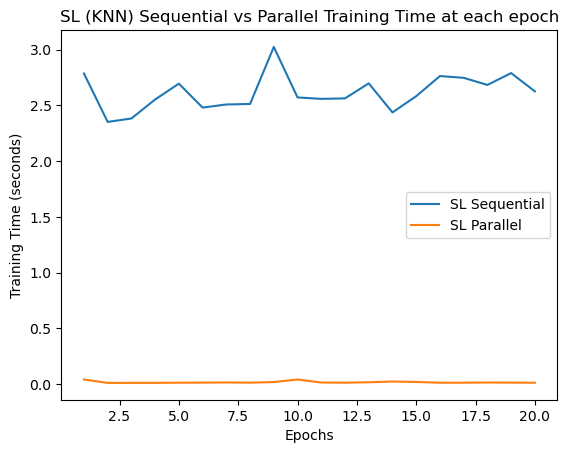

In [32]:
# Generate x-axis values for epochs
epochs = range(1, 21)

# Plot sequential and parallel training times for KNN
plt.plot(epochs, time_at_epoch_knn, label='SL Sequential')
plt.plot(epochs, time_at_epoch_knn_par, label='SL Parallel')

# Set the labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Time (seconds)')
plt.title('SL (KNN) Sequential vs Parallel Training Time at each epoch')

# # Set the y-axis scale to logarithmic this is because some values are so small and I have to display them on the graph
# plt.yscale('log')

# Display the legend
plt.legend()

# Show the plot
plt.show()

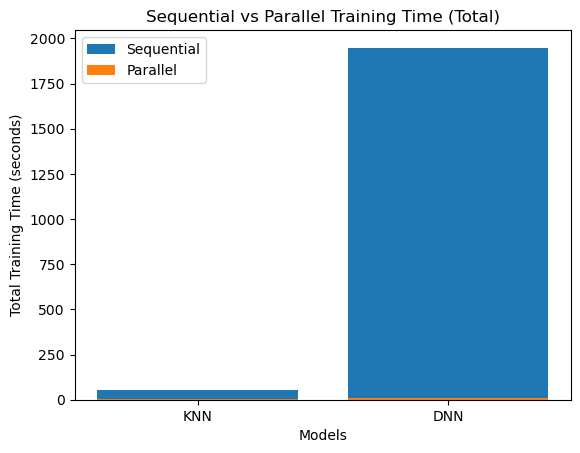

In [26]:
# Define the data
models = ['KNN', 'DNN']
sequential_times = [SL_seq_final_time, DL_seq_final_time]
parallel_times = [knn_total_time, dnn_total_time]

# Plot the bar graph
plt.bar(models, sequential_times, label='Sequential')
plt.bar(models, parallel_times, label='Parallel')

# Set the labels and title
plt.xlabel('Models')
plt.ylabel('Total Training Time (seconds)')
plt.title('Sequential vs Parallel Training Time (Total)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

## SL sequential Vs DL Sequential (Compare Performance metrics)


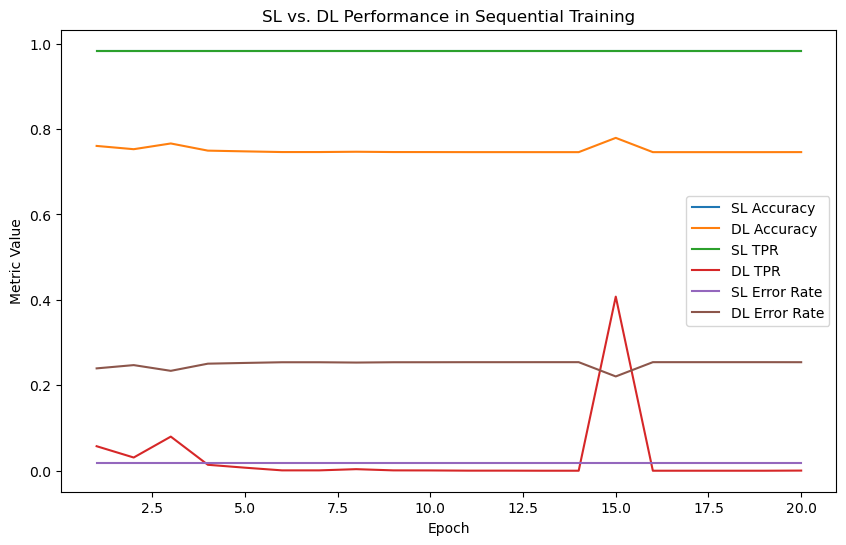

In [27]:
# Define the data for SL (KNN)
epochs = range(1, 21)
sl_acc = knn_acc
sl_tpr = tpr_knn
sl_error_rate = error_rate_knn

# Define the data for DL (DNN)
dl_acc = DL_acc_list
dl_tpr = tpr_dnn
dl_error_rate = error_rate_dnn

# Plot the line graph for SL and DL
plt.figure(figsize=(10, 6))
plt.plot(epochs, sl_acc, label='SL Accuracy')
plt.plot(epochs, dl_acc, label='DL Accuracy')
plt.plot(epochs, sl_tpr, label='SL TPR')
plt.plot(epochs, dl_tpr, label='DL TPR')
plt.plot(epochs, sl_error_rate, label='SL Error Rate')
plt.plot(epochs, dl_error_rate, label='DL Error Rate')

# Set the labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('SL vs. DL Performance in Sequential Training')

# Display the legend
plt.legend()

# Show the plot
plt.show()

## SL parallel Vs DL parallel training (Compare Performance metrics)

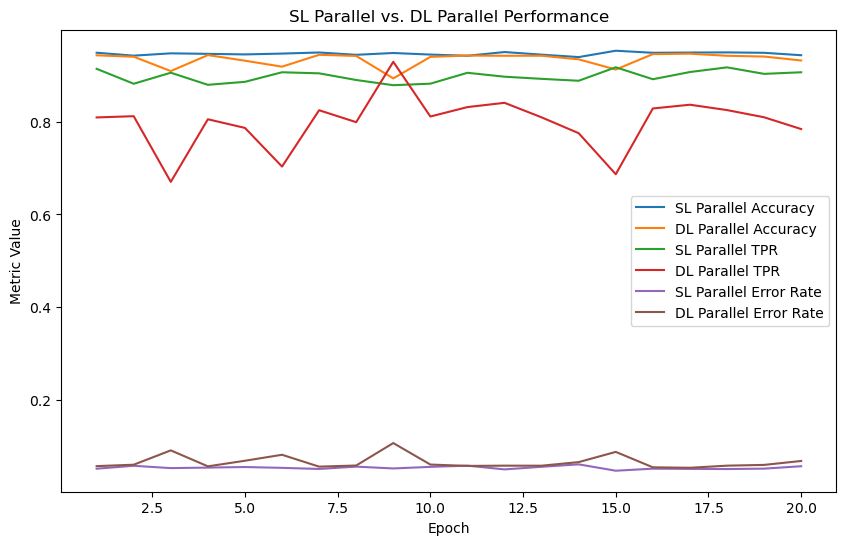

In [28]:
# Define the data for SL parallel (KNN)
sl_parallel_acc = knn_accuracy
sl_parallel_tpr = knn_tpr
sl_parallel_error_rate = knn_error_rate

# Define the data for DL parallel (DNN)
dl_parallel_acc = dnn_accuracy
dl_parallel_tpr = dnn_tpr
dl_parallel_error_rate = dnn_error_rate

# Plot the line graph for SL parallel and DL parallel
epochs = range(1, 21)
plt.figure(figsize=(10, 6))
plt.plot(epochs, sl_parallel_acc, label='SL Parallel Accuracy')
plt.plot(epochs, dl_parallel_acc, label='DL Parallel Accuracy')
plt.plot(epochs, sl_parallel_tpr, label='SL Parallel TPR')
plt.plot(epochs, dl_parallel_tpr, label='DL Parallel TPR')
plt.plot(epochs, sl_parallel_error_rate, label='SL Parallel Error Rate')
plt.plot(epochs, dl_parallel_error_rate, label='DL Parallel Error Rate')

# Set the labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('SL Parallel vs. DL Parallel Performance')

# Display the legend
plt.legend()

# Show the plot
plt.show()

## DL sequential Vs DL parallel training (Compare Time)

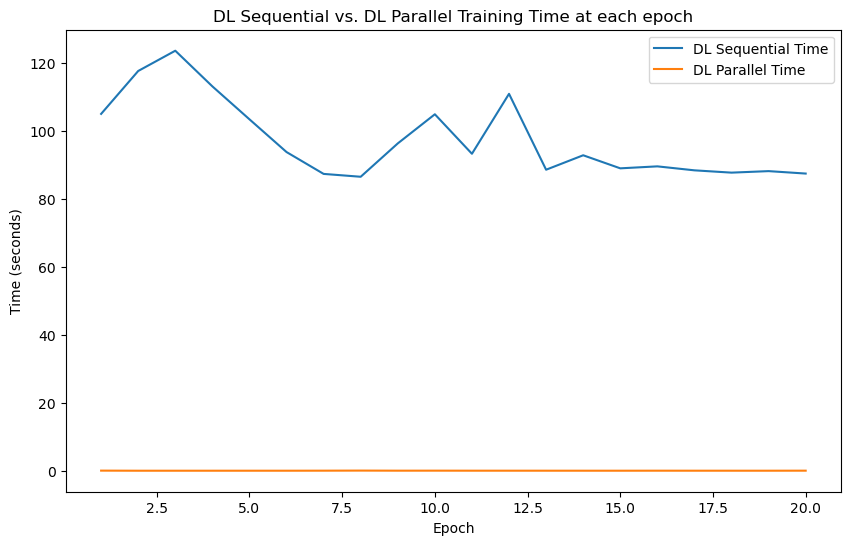

In [29]:
# Define the data for DL sequential and DL parallel
epochs = range(1, 21)
dl_seq_times = [time_at_epoch_dnn[i-1] for i in epochs]
dl_par_times = dnn_time_list

# Plot the line graph for DL sequential and DL parallel training times
plt.figure(figsize=(10, 6))
plt.plot(epochs, dl_seq_times, label='DL Sequential Time')
plt.plot(epochs, dl_par_times, label='DL Parallel Time')

# Set the labels and title
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('DL Sequential vs. DL Parallel Training Time at each epoch')

# Display the legend
plt.legend()

# Show the plot
plt.show()

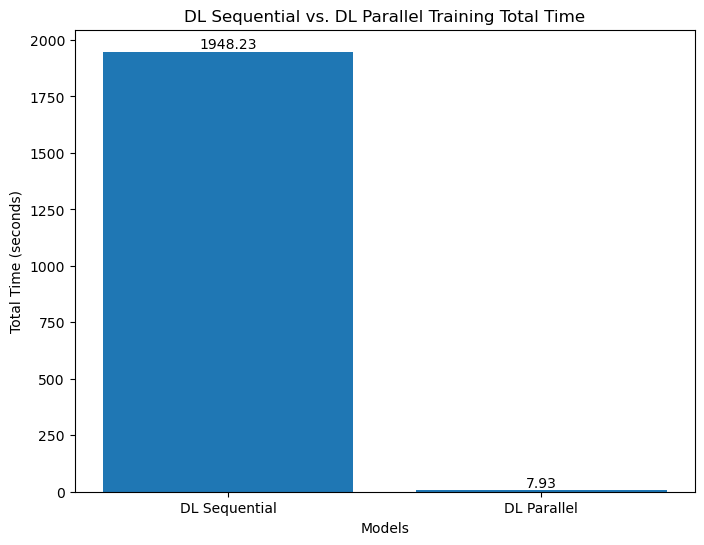

In [30]:
# Define the data for DL sequential and DL parallel
models = ['DL Sequential', 'DL Parallel']
times = [DL_seq_final_time, dnn_total_time]

# Plot the bar graph for DL sequential and DL parallel total training times
plt.figure(figsize=(8, 6))
plt.bar(models, times)

# Set the labels and title
plt.xlabel('Models')
plt.ylabel('Total Time (seconds)')
plt.title('DL Sequential vs. DL Parallel Training Total Time')

# Display the values on top of each bar
for i, time in enumerate(times):
    plt.text(i, time, str(round(time, 2)), ha='center', va='bottom')

# Show the plot
plt.show()